In [1]:
# If using GPU as accelerator
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sat May  9 03:54:56 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [23]:
from google.colab import drive, files
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
%cd "/content/drive/My Drive/Colab Notebooks/deep-learning-group"

/content/drive/My Drive/Colab Notebooks/deep-learning-group


In [0]:
import autoreload
%load_ext autoreload

In [0]:
%reload_ext autoreload

In [0]:
import glob
import cv2
import numpy as np
import os


from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, AveragePooling2D, Conv2D, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger, LearningRateScheduler
import csv
import helpers
import pandas as pd
import split_utils

In [7]:
DATA_DIR = '/content/drive/My Drive/Colab Notebooks/dataset'

batch_size_train = 200
val_size_train = 30
batch_size = 32

colorMode = 'rgb'
classMode = "categorical"
imgSize = 64

base_dir, train_dir, test_dir = split_utils.train_valid_split(DATA_DIR, 0.2, seed=1)

datagen = ImageDataGenerator(rotation_range=20,
                             width_shift_range=0.1,
                             height_shift_range=0.1, 
                             rescale=1./255,
                             zoom_range=0.3,
                             validation_split=0.25,
                             horizontal_flip=True)

train_generator = datagen.flow_from_directory(train_dir,
                                            target_size=(imgSize, imgSize),
                                            color_mode=colorMode,
                                            class_mode=classMode,
                                            batch_size=batch_size_train,
                                            subset='training')

validation_generator = datagen.flow_from_directory(train_dir,
                                            target_size=(imgSize, imgSize),
                                            color_mode=colorMode,
                                            class_mode=classMode,
                                            batch_size=batch_size_train,
                                            subset='validation')

Found 778 images belonging to 17 classes.
Found 254 images belonging to 17 classes.


**Callback functions list**

In [0]:
early_stop = EarlyStopping(monitor='val_accuracy',
                           min_delta=0.001,
                           patience=10)

**Simple CNN model**

In [0]:
def step_decay(epoch):
  initial_lrate = 0.1
  drop = 0.5
  epochs_drop = 10.0
  lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
  return lrate

lrate = LearningRateScheduler(step_decay)

In [0]:
cvsores_1 = []
filepath_1 = "Weights_1.best.hdf5"
checkpoint_1 = ModelCheckpoint(filepath_1, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

logpath_1 = "Model_1_history.csv"
log_1 = CSVLogger(logpath_1, append=False)

callback_list_1 = [early_stop, checkpoint_1, log_1, lrate]

def get_compiled_model_1(optimizer='adam', loss='categorical_crossentropy'):
  keras.backend.clear_session()
  model = Sequential([
                      Conv2D(32, activation='relu', kernel_size=3, input_shape=(imgSize, imgSize, 3)),
                      MaxPooling2D(pool_size=(2, 2)),
                      Conv2D(32, activation='relu', kernel_size=3),
                      MaxPooling2D(pool_size=(2, 2)),
                      Flatten(),
                      Dense(128, activation='relu'),
                      Dense(17, activation='softmax')
  ])
  model.compile(optimizer=optimizer,
                loss=loss,
                metrics=['accuracy'])
  return model

In [11]:
#@title Default title text
model_1 = get_compiled_model_1()

history = model_1.fit_generator(train_generator,
                      steps_per_epoch=30,
                      epochs=0,
                      validation_data=validation_generator,
                      validation_steps=20,
                      callbacks=callback_list_1)

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 1/50
30/30 [==============================] - ETA: 0s - loss: 2.6204 - accuracy: 0.1899
Epoch 00001: val_accuracy improved from -inf to 0.27165, saving model to Weights_1.best.hdf5
30/30 [==============================] - 50s 2s/step - loss: 2.6204 - accuracy: 0.1899 - val_loss: 2.3127 - val_accuracy: 0.2717
Epoch 2/50
30/30 [==============================] - ETA: 0s - loss: 2.0368 - accuracy: 0.3767
Epoch 00002: val_accuracy improved from 0.27165 to 0.37717, saving model to Weights_1.best.hdf5
30/30 [==============================] - 49s 2s/step - loss: 2.0368 - accuracy: 0.3767 - val_loss: 2.0223 - val_accuracy: 0.3772
Epoch 3/50
30/30 [==============================] - ETA: 0s - loss: 1.6888 - accuracy: 0.4784
Epoch 00003: val_accuracy improved from 0.37717 to 0.42835, saving model to Weights_1.best.hdf5
30/30 [==============================] - 51s 2s/step - loss: 1.6888 - accuracy: 0.4784 - val_loss: 1.9112 - val_accuracy: 0.4283
Epoch 4/50
30/30 [============================

In [0]:
del log_data

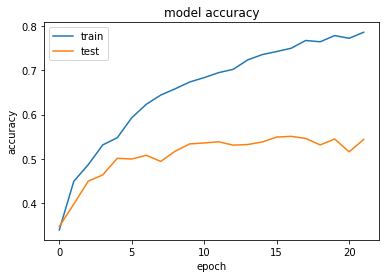

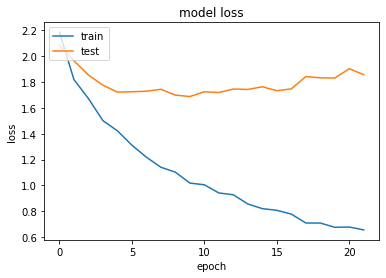

In [35]:
log_data = pd.read_csv(logpath_1)
helpers.plotTrainingHistory(log_data)

In [36]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               802944    
_________________________________________________________________
dense_1 (Dense)              (None, 17)                2

In [37]:
testgen = ImageDataGenerator(rescale=1./255)

test_generator = testgen.flow_from_directory(test_dir,
                                            target_size=(imgSize, imgSize),
                                            color_mode=colorMode,
                                            class_mode=classMode,
                                            batch_size=batch_size,
                                            shuffle=False)

y_pred = model_1.predict_generator(test_generator, steps = test_generator.samples//batch_size+1, verbose=1)

Found 266 images belonging to 17 classes.
Instructions for updating:
Please use Model.predict, which supports generators.
9/9 [==============================] - 43s 5s/step


In [0]:
le = LabelEncoder()
listLabel = list(test_generator.class_indices.keys())
le.fit(listLabel)
encodedLabel = le.transform(listLabel)

In [0]:
y_pred = np.argmax(y_pred, axis=1)

In [40]:
print(classification_report(test_generator.classes, y_pred))

              precision    recall  f1-score   support

           0       0.64      0.64      0.64        14
           1       0.73      0.61      0.67        18
           2       0.59      0.67      0.62        15
           3       0.67      0.43      0.52        14
           4       0.71      0.75      0.73        16
           5       0.75      0.60      0.67        15
           6       0.71      0.67      0.69        15
           7       0.50      0.44      0.47        18
           8       0.25      0.21      0.23        14
           9       0.50      0.44      0.47        18
          10       0.81      0.81      0.81        16
          11       0.85      0.73      0.79        15
          12       0.68      1.00      0.81        15
          13       0.53      0.53      0.53        15
          14       0.88      0.78      0.82        18
          15       0.64      0.93      0.76        15
          16       0.65      0.87      0.74        15

    accuracy              

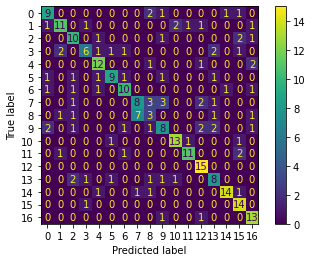

In [41]:
ConfusionMatrixDisplay(confusion_matrix(test_generator.classes, y_pred), encodedLabel).plot()

**Simple model using transfer learning**

In [0]:
cvscores_2 = []
def get_compiled_model_2():
  keras.backend.clear_seesion()
  baseModel = VGG16(weights='imagenet',
                    include_top=False,
                    input_tensor=Input(shape=(imgSize, imgSize, 3)))
  
  for layer in baseModel.layers[:-5]:
    layer.trainable = False
  
  

**Results Summary**